In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import pandas as pd
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

%reload_ext autoreload
%autoreload 2

In [2]:
data_dir = Path("./data/raw/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
image_width = 200
image_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'d', '6', '5', '3', 'p', 'f', 'm', 'c', '4', 'x', '8', 'y', '7', 'b', 'n', '2', 'w', 'g', 'e'}


In [3]:
characters = np.unique([char for label in labels for char in label])

In [4]:
# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), mask_token=None, invert=True
)
num_to_char

2022-11-13 09:54:45.849968: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:

from src.stages.split import split_data_from_config
# Splitting data into training and validation sets
split_data_from_config('./params.yaml');


/home/cedric/Projects/DataScience/CaptchaOCR/src/stages/split.py:28: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(config_file)


In [6]:
from src.stages.datasets import create_datasets_from_config
create_datasets_from_config('./params.yaml');


train_dataset = tf.data.experimental.load('./data/datasets/train_dataset', 
                                            {'image': tf.TensorSpec(shape=(None, image_width, image_height, 1), dtype=tf.float32, name=None), 
                                             'label': tf.TensorSpec(shape=(None, None), dtype=tf.int64, name=None)
                                            }
                                            )

validation_dataset = tf.data.experimental.load('./data/datasets/validation_dataset', 
                                            {'image': tf.TensorSpec(shape=(None, image_width, image_height, 1), dtype=tf.float32, name=None), 
                                             'label': tf.TensorSpec(shape=(None, None), dtype=tf.int64, name=None)
                                            }
                                            )

/home/cedric/Projects/DataScience/CaptchaOCR/src/stages/datasets.py:51: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(config_file)
2022-11-13 09:54:46.033952: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-13 09:54:46.054197: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1689600000 Hz


{'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}


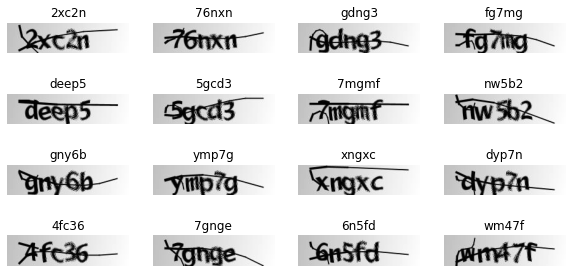

In [7]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [8]:
from src.custom_layers.CTC import CTCLayer
input_img = layers.Input(
    shape=(image_width, image_height, 1), name="image", dtype="float32"
    )
labels = layers.Input(name="label", shape=(None,), dtype="float32")

# First conv block
x = layers.Conv2D(
    32,
    (3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
    name="Conv1",
)(input_img)
x = layers.MaxPooling2D((2, 2), name="pool1")(x)

# Second conv block
x = layers.Conv2D(
    64,
    (3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
    name="Conv2",
)(x)
x = layers.MaxPooling2D((2, 2), name="pool2")(x)

# We have used two max pool with pool size and strides 2.
# Hence, downsampled feature maps are 4x smaller. The number of
# filters in the last layer is 64. Reshape accordingly before
# passing the output to the RNN part of the model
new_shape = ((image_width // 4), (image_height // 4) * 64)

x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
x = layers.Dense(64, activation="relu", name="dense1")(x)
x = layers.Dropout(0.2)(x)

# RNNs
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

# Output layer
x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

# Add CTC layer for calculating CTC loss at each step
output = CTCLayer(name="ctc_loss")(labels, x)

# Define the model
model = keras.models.Model(
    inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
)
# Optimizer
opt = keras.optimizers.Adam()
# Compile the model and return
model.compile(optimizer=opt)
    

In [9]:
from src.stages.model_setup import create_model_from_config

create_model_from_config('./params.yaml')

model = tf.keras.models.load_model('./models/untrained_model.h5')

ModuleNotFoundError: No module named 'src.stages.model'

In [ ]:
#tf.keras.utils.plot_model(model)

In [ ]:
epochs = 100
early_stopping_patience = 5 
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

In [ ]:
fig,ax = plt.subplots(ncols=2)

ax[0].plot(history.epoch[1:], history.history['loss'][1:])
ax[0].plot(history.epoch[1:], history.history['val_loss'][1:])

ax[1].semilogy(history.epoch[1:], history.history['loss'][1:])
ax[1].semilogy(history.epoch[1:], history.history['val_loss'][1:])

In [ ]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

acc_score = 0

#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    m = len(pred_texts)
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    
    
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        if str(pred_texts[i]) == orig_texts[i]:
            acc_score+=1
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
print("Validation Score:" + str(acc_score/m * 100))